# FACTS devices

We implement the FACTS devices Static Var Compensator (SVC) and Thyristor-Controlled Series Capacitor (TCSC) based on the PhD Thesis of Ara Panosyan, PhD.

We reproduce the case study from the PhD Thesis using the following grid model:

![title](facts/facts_case_study_grid.png)

## Reference: case study grid

In [1]:
import os
import tempfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import pandapower as pp
from pandapower.test.loadflow.test_facts import facts_case_study_grid
from pandapower.timeseries import DFData, OutputWriter
from pandapower.timeseries.run_time_series import run_timeseries
from pandapower.control import ConstControl
from pandapower.pf.create_jacobian_facts import calc_y_svc_pu

In [2]:
net = facts_case_study_grid()

In [3]:
#### define and prepare the generation and loads profiles.

wind_profile = pd.read_csv(r"facts/facts_case_study_wind_profile.csv", index_col=0)

In [4]:
time_steps = wind_profile.index.values

In [5]:
wind_ds = DFData(wind_profile)

In [6]:
ConstControl(net, element='gen', variable='p_mw', element_index=net.gen.index,
             data_source=wind_ds, profile_name=["wind_power_mw"])

This ConstControl has the following parameters: 

index:             0
json_excludes:     ['self', '__class__']

In [7]:
ow = OutputWriter(net, time_steps, output_path=None)
ow.log_variable("res_bus", "vm_pu")
ow.log_variable("res_trafo", "q_hv_mvar")
ow.log_variable("res_trafo", "q_lv_mvar")
ow.log_variable("res_gen", "p_mw")

In [8]:
run_timeseries(net, time_steps, continue_on_divergence=False, recycle=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 32.40it/s]


In [9]:
vm_pu = ow.output["res_bus.vm_pu"].copy()

In [10]:
def plot_result(result, title, ylabel, ylim, yticks=None, legend=False):
    ax=result.plot(legend=legend)
    ax.set_title(title, size=18)
    ax.set_ylabel(ylabel,size=14)
    ax.set_xlabel("Time (h)",size=14)
    ax.set_xscale('linear')
    locs = np.array([-24,   0,  24,  48,  72,  95])
    labels = ['00:00','00:00','06:00','12:00','18:00',"23:45"]
    ax.set_xticks(locs, labels)
    ax.set_xlim([0, 95])
    ax.set_ylim(ylim)
    if yticks is not None:
        ax.set_yticks(yticks)

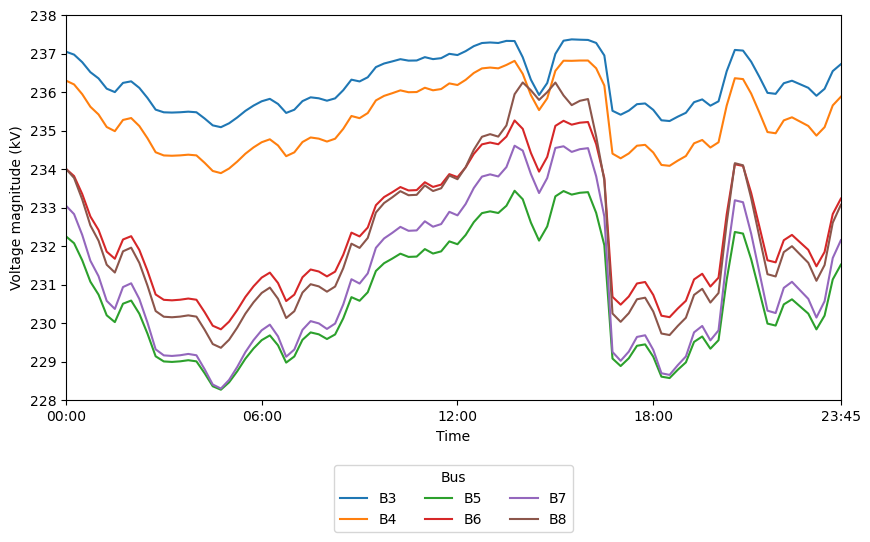

In [11]:
def plot_voltage(vm_pu, net, ax):
    vm_pu.columns = net.bus.name.values
    (230*vm_pu.iloc[:, 2:]).plot(ax=ax, label=net.bus.name.values)
    ax.legend(loc="upper center", ncols=3, bbox_to_anchor=(0.5, -0.15), title="Bus")

    ax.set_ylabel("Voltage magnitude (kV)")
    ax.set_xlabel("Time")

    ax.set_xscale('linear')

    locs = np.array([-24,   0,  24,  48,  72,  95])
    labels = ['00:00','00:00','06:00','12:00','18:00',"23:45"]
    ax.set_xticks(locs, labels)
    ax.set_xlim([0, 95])
    ax.set_ylim([228, 238])
    ax.set_yticks(np.arange(228,239,1))

_, (ax) = plt.subplots(1, 1, figsize=(10, 5))
plot_voltage(vm_pu, net, ax=ax)

## SVC use case 

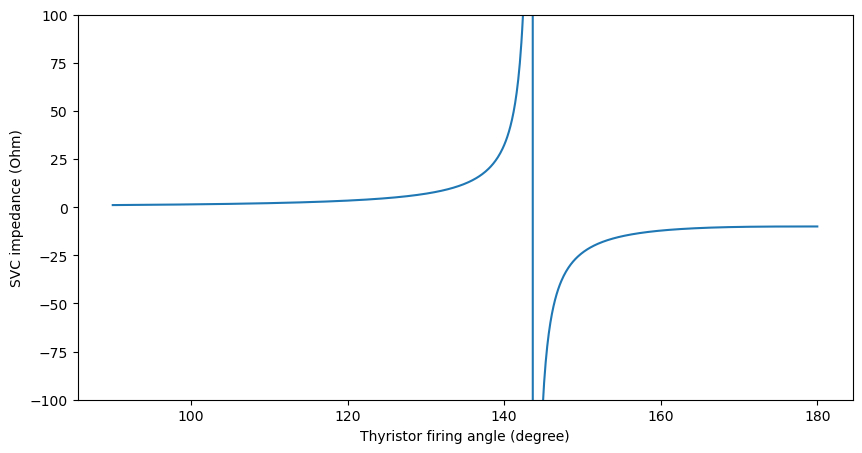

In [12]:
baseV = 230
baseMVA = 1
baseZ = baseV ** 2 / baseMVA

x = np.arange(90,180.1, 0.1)
y = calc_y_svc_pu(np.deg2rad(x), 1 / baseZ, -10 / baseZ)

_, (ax) = plt.subplots(1, 1, figsize=(10, 5))
ax.plot(x, 1 / y * baseZ)
ax.set_ylim(-100, 100)
ax.set_xlabel("Thyristor firing angle (degree)")
ax.set_ylabel("SVC impedance (Ohm)");

In [13]:
pp.create_svc(net, bus=6, x_l_ohm=1, x_cvar_ohm=-10, set_vm_pu=1., thyristor_firing_angle_degree=90, controllable=True)
net.svc

,name,bus,x_l_ohm,x_cvar_ohm,set_vm_pu,thyristor_firing_angle_degree,controllable,in_service,min_angle_degree,max_angle_degree
0,None,6,1.0,-10.0,1.0,90.0,True,True,90.0,180.0


In [14]:
pp.runpp(net)

In [15]:
net.res_svc

,thyristor_firing_angle_degree,x_ohm,q_mvar,vm_pu,va_degree
0,143.625202,5787.137911,9.140961,1.0,-0.476388


In [16]:
ow.log_variable("res_svc", "thyristor_firing_angle_degree")
run_timeseries(net, time_steps=time_steps, continue_on_divergence=True, recycle=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:02<00:00, 43.81it/s]


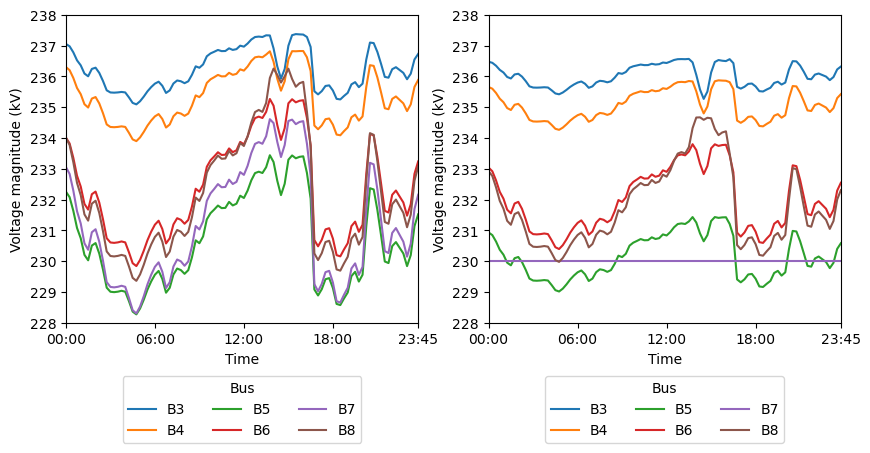

In [17]:
vm_pu_svc = ow.output["res_bus.vm_pu"].copy()

_, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
plot_voltage(vm_pu, net, ax=ax1)
plot_voltage(vm_pu_svc, net, ax2)

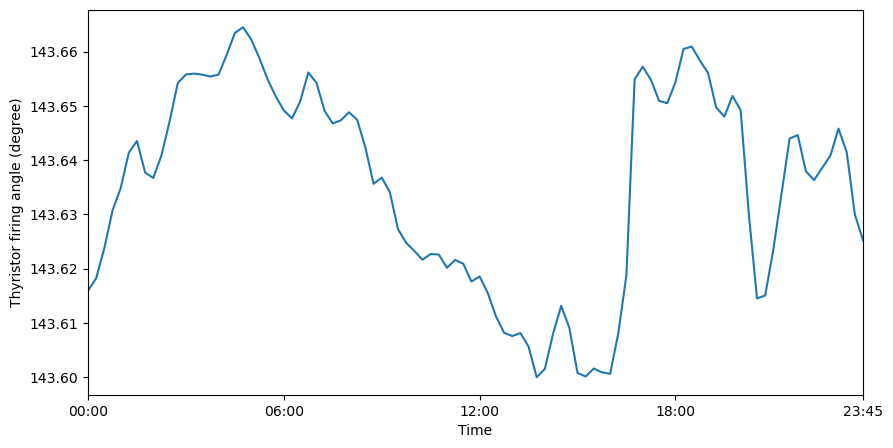

In [18]:
_, (ax) = plt.subplots(1, 1, figsize=(10, 5))
firing_angle = ow.output["res_svc.thyristor_firing_angle_degree"]
firing_angle.plot(legend=False, ax=ax)
ax.set_ylabel("Thyristor firing angle (degree)")
ax.set_xlabel("Time")
ax.set_xscale('linear')
locs = np.array([-24,   0,  24,  48,  72,  95])
labels = ['00:00','00:00','06:00','12:00','18:00',"23:45"]
ax.set_xticks(locs, labels)
ax.set_xlim([0, 95]);

## TCSC use case

In [19]:
xl = 7.6
xc = -47

f = net.bus.loc[net.bus.name == "B4"].index.values[0]
t = net.bus.loc[net.bus.name == "B6"].index.values[0]
aux = pp.create_bus(net, 230, "aux")
l = net.line.loc[(net.line.from_bus == f) & (net.line.to_bus == t)].index.values[0]
net.line.loc[l, "from_bus"] = aux

pp.create_tcsc(net, from_bus=f, to_bus=aux, x_l_ohm=xl, x_cvar_ohm=xc, set_p_to_mw=-100, 
               thyristor_firing_angle_degree=140, controllable=True)
net.svc.in_service = False

net.tcsc

,name,from_bus,to_bus,x_l_ohm,x_cvar_ohm,set_p_to_mw,thyristor_firing_angle_degree,controllable,in_service,min_angle_degree,max_angle_degree
0,None,3,8,7.6,-47.0,-100.0,140.0,True,True,90.0,180.0


In [20]:
pp.runpp(net)
net.res_tcsc

,thyristor_firing_angle_degree,x_ohm,p_from_mw,q_from_mvar,p_to_mw,q_to_mvar,pl_mw,ql_mvar,i_ka,vm_from_pu,va_from_degree,vm_to_pu,va_to_degree
0,119.797017,32.661474,100.0,-4.939336,-100.0,10.85824,0.0,5.918904,0.245778,1.022583,8.646513,1.027341,5.277211


In [21]:
ow.log_variable("res_tcsc", "thyristor_firing_angle_degree")
ow.log_variable("res_tcsc", "p_from_mw")
ow.log_variable("res_tcsc", "q_from_mvar")
ow.log_variable("res_tcsc", "ql_mvar")

run_timeseries(net, time_steps[:48], continue_on_divergence=True, recycle=False, max_iteration=100)
p_controllable = ow.output["res_tcsc.p_from_mw"].copy()

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 29.10it/s]


In [22]:
net.tcsc.controllable = False
net.tcsc.thyristor_firing_angle_degree = 90
run_timeseries(net, time_steps[48:], continue_on_divergence=True, recycle=False, max_iteration=100)
p_not_controllable = ow.output["res_tcsc.p_from_mw"].copy()
p_total = pd.concat([p_controllable, p_not_controllable])

100%|██████████████████████████████████████████████████████████████████████████████████| 48/48 [00:01<00:00, 38.90it/s]


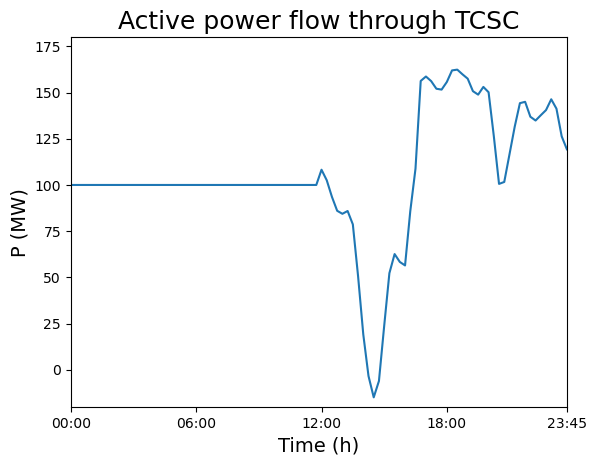

In [23]:
plot_result(p_total, "Active power flow through TCSC", "P (MW)", [-20, 180])